# FISH - Data interpretation - A Python interactive notebook to interpret FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.

```

### Notebook summary 


- Load a directory with data quantified by FISH_pipeline.ipynb
- Establish a connection to Network-attached storage (NAS) using [pysmb](https://github.com/miketeo/pysmb)
- Compares quantifications for multiple conditions in a single plot
- Compares mRNA spots in the  nucleus, cytosol and the comple cell.
  
----

<img src= /home/luisub/Desktop/FISH_Processing/docs/images/code_architecture.png alt="drawing" width="1000"/>

## Importing libraries

In [1]:
import sys
import matplotlib.pyplot as plt 
from  matplotlib.ticker import FuncFormatter
import numpy as np 
import pandas as pd
import pathlib
import warnings
import glob
import seaborn as sns
import zipfile
import shutil
warnings.filterwarnings("ignore")

## Defining paths

In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

# Local folder path
local_folder_path = pathlib.Path().absolute().joinpath('temp_zip_analyses')
local_folder_path

# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'

# Connection to munsky-nas
path_to_config_file = desktop_path.joinpath('config.yml')
share_name = 'share'

## List of folders to process

In [3]:
def dusp__dirs(mandatory_substring):
    list_dirs=(
    'smFISH_images/Eric_smFISH_images/20220126/DUSP1_Dex_0min' ,
    'smFISH_images/Eric_smFISH_images/20220126/DUSP1_Dex_10min' ,
    'smFISH_images/Eric_smFISH_images/20220126/DUSP1_Dex_20min' ,
    'smFISH_images/Eric_smFISH_images/20220126/DUSP1_Dex_30min' ,
    'smFISH_images/Eric_smFISH_images/20220126/DUSP1_Dex_40min' ,
    'smFISH_images/Eric_smFISH_images/20220131/DUSP1_Dex_50min' ,
    'smFISH_images/Eric_smFISH_images/20220131/DUSP1_Dex_60min' ,
    'smFISH_images/Eric_smFISH_images/20220131/DUSP1_Dex_75min' ,
    'smFISH_images/Eric_smFISH_images/20220131/DUSP1_Dex_90min' ,
    'smFISH_images/Eric_smFISH_images/20220131/DUSP1_Dex_120min' ,
    'smFISH_images/Eric_smFISH_images/20220131/DUSP1_Dex_150min' ,
    'smFISH_images/Eric_smFISH_images/20220131/DUSP1_Dex_180min' )
    list_labels = [ 'wo','10min','20min','30min','40min','50min','60min','75min','90min','120min','150min','180min']
    plot_title_subfix= "DUSP1_Dex"
    mandatory_substring = mandatory_substring #'nuc_100__cyto_220__psfz_300__psfyx_105'
    return list_dirs, list_labels, plot_title_subfix, mandatory_substring

In [4]:
def IL_R2_list(mandatory_substring):
    list_dirs=(
    'smFISH_images/Linda_smFISH_images/Confocal/20220214/GAPDH-Cy3_NFKBIA-Cy5_WO_10ng_mL_IL-1B_Rep2' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220214/GAPDH-Cy3_NFKBIA-Cy5_5min_10ng_mL_IL-1B_Rep2' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220209/GAPDH-Cy3_NFKBIA-Cy5_10min_10ng_mL_IL-1B_Rep2' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220209/GAPDH-Cy3_NFKBIA-Cy5_15min_10ng_mL_IL-1B_Rep2' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220209/GAPDH-Cy3_NFKBIA-Cy5_20min_10ng_mL_IL-1B_Rep2' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220207/GAPDH-Cy3_NFKBIA-Cy5_30min_10ng_mL_IL-1B_Rep2' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220207/GAPDH-Cy3_NFKBIA-Cy5_1h_10ng_mL_IL-1B_Rep2' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220207/GAPDH-Cy3_NFKBIA-Cy5_2h_10ng_mL_IL-1B_Rep2' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220207/GAPDH-Cy3_NFKBIA-Cy5_3h_10ng_mL_IL-1B_Rep2' ) 
    list_labels = [ 'wo','5min','10min','15min','20min','30min','1h', '2h','3h']
    plot_title_subfix= "GAPDH-Cy3_NFKBIA-Cy5_IL-1B_Rep2"
    mandatory_substring = mandatory_substring   #'nuc_100__cyto_220__psfz_350__psfyx_120'
    return list_dirs, list_labels, plot_title_subfix, mandatory_substring

In [5]:
def IL_R1_list(mandatory_substring):
    list_dirs=(
    'smFISH_images/Linda_smFISH_images/Confocal/20220125/GAPDH-Cy3_NFKBIA-Cy5_WO_IL-1B',
    'smFISH_images/Linda_smFISH_images/Confocal/20220203/GAPDH-Cy3_NFKBIA-Cy5_5min_10ng_mL_IL-1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220127/GAPDH-Cy3_NFKBIA-Cy5_10min_10ng_mL_IL-1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220125/GAPDH-Cy3_NFKBIA-Cy5_15min_10ng_mL_IL-1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220125/GAPDH-Cy3_NFKBIA-Cy5_20min_10ng_mL_IL-1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220124/GAPDH-Cy3_NFKBIA-Cy5_30min_10ng_mL_IL-1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220124/GAPDH-Cy3_NFKBIA-Cy5_1h_10ng_mL_IL-1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220124/GAPDH-Cy3_NFKBIA-Cy5_2h_10ng_mL_IL-1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220124/GAPDH-Cy3_NFKBIA-Cy5_3h_10ng_mL_IL-1B' ) 
    list_labels = [ 'wo','5min','10min','15min','20min','30min','1h', '2h','3h']
    plot_title_subfix= "GAPDH-Cy3_NFKBIA-Cy5_IL-1B_Rep1"
    mandatory_substring = mandatory_substring    #'nuc_100__cyto_220__psfz_350__psfyx_120'
    return list_dirs, list_labels, plot_title_subfix, mandatory_substring

In [6]:
def Dex_R1_list(mandatory_substring):
    list_dirs=(
    'smFISH_images/Linda_smFISH_images/Confocal/20220114/GAPDH-Cy3_NFKBIA-Cy5_woDex' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220121/GAPDH-Cy3_NFKBIA-Cy5_5min_100nMDex' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220121/GAPDH-Cy3_NFKBIA-Cy5_10min_100nMDex' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220124/GAPDH-Cy3_NFKBIA-Cy5_15min_100nMDex' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220124/GAPDH-Cy3_NFKBIA-Cy5_30min_100nMDex' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220117/GAPDH-Cy3_NFKBIA-Cy5_1h_100nMDex' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220114/GAPDH-Cy3_NFKBIA-Cy5_2h_100nMDex' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220117/GAPDH-Cy3_NFKBIA-Cy5_4h_100nMDex' )
    list_labels = [ 'wo','5min','10min','15min','30min','1h', '2h','4h']
    plot_title_subfix= "GAPDH-Cy3_NFKBIA-Cy5_100nMDex_Rep1"
    mandatory_substring = mandatory_substring       #'nuc_100__cyto_220__psfz_350__psfyx_120'
    return list_dirs, list_labels, plot_title_subfix, mandatory_substring

In [7]:
def Dex_R2_list(mandatory_substring):
    list_dirs=(    
    'smFISH_images/Linda_smFISH_images/Confocal/20220214/GAPDH-Cy3_NFKBIA-Cy5_WO_DEX_Rep2' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220216/GAPDH-Cy3_NFKBIA-Cy5_5min_100nM_DEX_Rep2' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220216/GAPDH-Cy3_NFKBIA-Cy5_10min_100nM_DEX_Rep2' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220216/GAPDH-Cy3_NFKBIA-Cy5_15min_100nM_DEX_Rep2' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220215/GAPDH-Cy3_NFKBIA-Cy5_30min_100nM_DEX_Rep2' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220214/GAPDH-Cy3_NFKBIA-Cy5_1h_100nM_DEX_Rep2' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220214/GAPDH-Cy3_NFKBIA-Cy5_2h_100nM_DEX_Rep2' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220214/GAPDH-Cy3_NFKBIA-Cy5_4h_100nM_DEX_Rep2' )
    list_labels = [ 'wo','5min','10min','15min','30min','1h', '2h','4h']
    plot_title_subfix= "GAPDH-Cy3_NFKBIA-Cy5_100nM_DEX_Rep2"
    mandatory_substring = mandatory_substring      #'nuc_100__cyto_220__psfz_350__psfyx_120'
    return list_dirs, list_labels, plot_title_subfix, mandatory_substring

In [8]:
def Cox_ILb_list(mandatory_substring):
    list_dirs=(  
    'smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_wo_IL-1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_30ng_ml_IL-1B_2h' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_30ng_ml_IL-1B_6h' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_100ng_ml_IL-1B_2h' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_100ng_ml_IL-1B_6h' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220315/GAPDH-Cy3_COX-2-Cy5_300ng_ml_IL-1B_2h' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220315/GAPDH-Cy3_COX-2-Cy5_300ng_ml_IL-1B_6h' )
    list_labels = [ 'wo','2h_30ng','6h_30ng','2h_100ng','6h_100ng','2h_300ng','6h_300ng']
    plot_title_subfix= "GAPDH-Cy3_COX-2-Cy5_IL1B"
    mandatory_substring = mandatory_substring      #'nuc_100__cyto_220__psfz_350__psfyx_120'
    return list_dirs, list_labels, plot_title_subfix, mandatory_substring

In [9]:
def Cox_test_ILb(mandatory_substring):
    list_dirs=(  
    'smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_wo_IL-1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_30ng_ml_IL-1B_2h' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_30ng_ml_IL-1B_6h' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_100ng_ml_IL-1B_2h' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220314/GAPDH-Cy3_COX-2-Cy5_100ng_ml_IL-1B_6h' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220315/GAPDH-Cy3_COX-2-Cy5_300ng_ml_IL-1B_2h' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220315/GAPDH-Cy3_COX-2-Cy5_300ng_ml_IL-1B_6h' )
    list_labels = [ 'wo','2h_30ng','6h_30ng','2h_100ng','6h_100ng','2h_300ng','6h_300ng']
    plot_title_subfix= "test_GAPDH-Cy3_COX-2-Cy5_IL1B_ts_auto"
    mandatory_substring = mandatory_substring      #'nuc_90__cyto_180__psfz_350__psfyx_120__ts_400'
    return list_dirs, list_labels, plot_title_subfix, mandatory_substring

In [10]:
def Cox_DEX_100ng(mandatory_substring):
    list_dirs=(  
    'smFISH_images/Linda_smFISH_images/Confocal/20220324/GAPDH-Cy3_COX-2-Cy5_WO_Dex_IL1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220324/GAPDH-Cy3_COX-2-Cy5_10min_100nM_DEX' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220325/GAPDH-Cy3_COX-2-Cy5_20min_100nM_DEX' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220325/GAPDH-Cy3_COX-2-Cy5_30min_100nM_DEX' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220328/GAPDH-Cy3_COX-2-Cy5_45min_100nM_DEX' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220328/GAPDH-Cy3_COX-2-Cy5_60min_100nM_DEX' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220328/GAPDH-Cy3_COX-2-Cy5_2h_100nM_DEX' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220328/GAPDH-Cy3_COX-2-Cy5_4h_100nM_DEX')
    list_labels = [ 'wo','10m','20m','30m','45m','60m','120m','240m']
    plot_title_subfix= "GAPDH-Cy3_COX-2-Cy5_100nM_DEX_ts_auto"
    mandatory_substring = mandatory_substring      #'nuc_90__cyto_180__psfz_350__psfyx_120__ts_400'
    return list_dirs, list_labels, plot_title_subfix, mandatory_substring

In [11]:
def Cox_ILb_30ng(mandatory_substring):
    list_dirs=(  
    'smFISH_images/Linda_smFISH_images/Confocal/20220324/GAPDH-Cy3_COX-2-Cy5_WO_Dex_IL1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220328/GAPDH-Cy3_COX-2-Cy5_6min_30ng_mL_IL1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220328/GAPDH-Cy3_COX-2-Cy5_12min_30ng_mL_IL1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220329/GAPDH-Cy3_COX-2-Cy5_18min_30ng_mL_IL1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220329/GAPDH-Cy3_COX-2-Cy5_24min_30ng_mL_IL1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220329/GAPDH-Cy3_COX-2-Cy5_30min_30ng_mL_IL1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220330/GAPDH-Cy3_COX-2-Cy5_36min_30ng_mL_IL1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220330/GAPDH-Cy3_COX-2-Cy5_42min_30ng_mL_IL1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220331/GAPDH-Cy3_COX-2-Cy5_48min_30ng_mL_IL1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220331/GAPDH-Cy3_COX-2-Cy5_60min_30ng_mL_IL1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220328/GAPDH-Cy3_COX-2-Cy5_2h_30ng_mL_IL1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220331/GAPDH-Cy3_COX-2-Cy5_3h_30ng_mL_IL1B' ,
    'smFISH_images/Linda_smFISH_images/Confocal/20220401/GAPDH-Cy3_COX-2-Cy5_4h_30ng_mL_IL1B' )
    list_labels = [ 'wo','6m','12m','18m','24m','30m','36m','42m','48m','60m','120m','180m','240m']
    plot_title_subfix= "GAPDH-Cy3_COX-2-Cy5_30ng_IL1B_ts_auto"
    mandatory_substring = mandatory_substring      #'nuc_90__cyto_140__psfz_350__psfyx_120__ts_300'
    return list_dirs, list_labels, plot_title_subfix, mandatory_substring

## Establishing connection to NAS and downloading zip files.

In [12]:
def read_zipfiles_from_NAS(list_dirs,path_to_config_file,share_name,mandatory_substring,local_folder_path):
    # This function iterates over all zip files in a remote directory and download them to a local directory
    list_remote_files=[]
    list_local_files =[]
    for folder in list_dirs:
        list_files = fa.NASConnection(path_to_config_file,share_name = share_name).read_files(folder,timeout=60)
        for file in list_files:
            if ('.zip' in file) and (mandatory_substring in file):   # add an argument with re conditions 
                # Listing all zip files
                zip_file_path = pathlib.Path().joinpath(folder,file)
                list_remote_files.append (zip_file_path)
                list_local_files.append(pathlib.Path().joinpath(local_folder_path,zip_file_path.name)) 
                # downloading the zip files from NAS
                fa.NASConnection(path_to_config_file,share_name = share_name).download_file(zip_file_path, local_folder_path,timeout=200)
    return list_local_files

## Unzipping Files

In [13]:
def unzip_local_folders(list_local_files,local_folder_path):
    list_local_folders =[]
    for zip_folder in list_local_files:
        # Reads from a list of zip files
        file_to_unzip = zipfile.ZipFile(str(zip_folder)) # opens zip
        temp_folder_name = pathlib.Path().joinpath(local_folder_path, zip_folder.stem)
        if (os.path.exists(temp_folder_name)) :
            shutil.rmtree(temp_folder_name)
            os.makedirs(temp_folder_name) # make a new directory
        # Iterates for each file in zip file
        for file_in_zip in file_to_unzip.namelist():
            # Extracts data to specific folder
            file_to_unzip.extract(file_in_zip,temp_folder_name)
        # Closes the zip file
        file_to_unzip.close()
        # removes the original zip file
        os.remove(pathlib.Path().joinpath(local_folder_path, zip_folder.name))
        list_local_folders.append(temp_folder_name)
    return list_local_folders


In [14]:
def dataframe_extract_data(dataframe,spot_type_selected = 0):
    ''' This function is intended to read a dataframe and returns 
        number_of_spots_per_cell, number_of_spots_per_cell_cytosol, number_of_spots_per_cell_nucleus, number_of_TS_per_cell, ts_size, cell_size
    '''
    number_cells = dataframe['cell_id'].nunique()
    # Number of spots
    number_of_spots_per_cell = np.asarray([len( dataframe.loc[  (dataframe['cell_id']==i)  & (dataframe['spot_type']==spot_type_selected) ].spot_id) for i in range(0, number_cells)])
    # Number of spots in cytosol
    number_of_spots_per_cell_cytosol = np.asarray([len( dataframe.loc[  (dataframe['cell_id']==i) & (dataframe['is_nuc']==False) & (dataframe['spot_type']==spot_type_selected) ].spot_id) for i in range(0, number_cells)])
    # Number of spots in nucleus.  Spots without TS.
    number_of_spots_per_cell_nucleus = np.asarray([len( dataframe.loc[  (dataframe['cell_id']==i) &  (dataframe['is_cluster']==False) & (dataframe['is_nuc']==True) & (dataframe['is_nuc']==True) & (dataframe['spot_type']==spot_type_selected)    ].spot_id) for i in range(0, number_cells)])
    # Number of TS per cell.
    number_of_TS_per_cell = [len( dataframe.loc[  (dataframe['cell_id']==i) &  (dataframe['is_cluster']==True) & (dataframe['is_nuc']==True) & (dataframe['spot_type']==spot_type_selected) & (dataframe['cluster_size'] >=4) ].spot_id) for i in range(0, number_cells)]
    number_of_TS_per_cell= np.asarray(number_of_TS_per_cell)
    # Number of RNA in a TS
    ts_size =  dataframe.loc[   (dataframe['is_cluster']==True) & (dataframe['is_nuc']==True)  & (dataframe['spot_type']==spot_type_selected)   ].cluster_size.values
    # Size of each cell
    cell_size = np.asarray([len( dataframe.loc[  (dataframe['cell_id']==i) & (dataframe['spot_type']==0)].cell_area_px.values) for i in range(0, number_cells)])
    return number_of_spots_per_cell, number_of_spots_per_cell_cytosol, number_of_spots_per_cell_nucleus, number_of_TS_per_cell, ts_size,cell_size, number_cells


In [15]:
def extracting_data_for_each_df_in_directory(data_dir):
    '''
    '''
    # Extracting data from dataframe and converting it into lists for each directory.
    list_spots_total=[]
    list_spots_nuc=[]
    list_spots_cytosol=[]
    list_number_cells =[]
    list_transcription_sites =[]
    for i in range (0, len (data_dir)):
        dataframe_dir = current_dir.joinpath('analyses',data_dir[i])    # loading files from "analyses" folder
        dataframe_file = glob.glob( str(dataframe_dir.joinpath('dataframe_*')) )[0]
        df = pd.read_csv(dataframe_file) 
        # Exctracting values from dataframe
        number_of_spots_per_cell, number_of_spots_per_cell_cytosol, number_of_spots_per_cell_nucleus, number_of_TS_per_cell, ts_size, cell_size, number_cells = dataframe_extract_data(df)
        # Appending each condition to a list
        list_spots_total.append(number_of_spots_per_cell)  # This list includes spots and TS in the nucleus
        list_spots_nuc.append(number_of_spots_per_cell_nucleus)   #
        list_spots_cytosol.append(number_of_spots_per_cell_cytosol)
        list_number_cells.append(number_cells)
        list_transcription_sites.append(number_of_TS_per_cell)
        # Deleting variables
        del number_of_spots_per_cell, number_of_spots_per_cell_cytosol, number_of_spots_per_cell_nucleus, number_of_TS_per_cell, ts_size, cell_size, number_cells
    return list_spots_total, list_spots_nuc, list_spots_cytosol, list_number_cells, list_transcription_sites


In [16]:
def convert_list_to_df (list_number_cells, list_spots, list_labels, remove_extreme_values= False) :
    # defining the dimensions for the array.
    max_number_cells = max(list_number_cells)
    number_conditions = len(list_number_cells)
    # creating an array with the same dimensions
    spots_array = np.empty((max_number_cells,number_conditions))
    spots_array[:] = np.NaN
    # replace the elements in the array
    for i in range(0,number_conditions ):
        spots_array[0:list_number_cells[i],i] = list_spots[i] 
    # creating a dataframe
    df = pd.DataFrame(data=spots_array, columns=list_labels)
    
    # Removing 1% extreme values.
    if remove_extreme_values == True:
        for col in df.columns:
            max_data_value= df[col].quantile(0.99)
            df[col] = np.where(df[col]>=max_data_value, np.nan, df[col])
    return df


In [17]:
def dist_plots(df, plot_title,destination_folder ):
    
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    
    # Violin plots
    plt.figure(figsize=(10,5))
    sns.set(font_scale = 1)
    sns.set_style("whitegrid")
    p_dist =sns.violinplot(data=df, scale="count",palette="OrRd")
    p_dist.set_xlabel("Spot count")
    p_dist.set_ylabel("Count")
    p_dist.set_title(plot_title)
    #p_dist.set_ylim(-10,max_val)
    name_plot = 'Vio_'+plot_title+'.png'
    plt.savefig(name_plot, transparent=False)
    plt.show()
    pathlib.Path().absolute().joinpath(name_plot).rename(pathlib.Path().absolute().joinpath(destination_folder,name_plot))

    # Distribution
    plt.figure(figsize=(10,5))
    sns.set(font_scale = 1)
    sns.set_style("whitegrid")
    p_dist =sns.kdeplot(data=df,palette="OrRd")
    p_dist.set_xlabel("Spots")
    p_dist.set_ylabel("Kernel Density Estimator (KDE)")
    p_dist.set_title(plot_title)
    #sns.set(font_scale = 1)
    #p_dist.set_xlim(-10,max_val)
    name_plot = 'Dist_'+plot_title+'.png'
    plt.savefig(name_plot, transparent=False,dpi=300, bbox_inches = "tight")
    plt.show()
    pathlib.Path().absolute().joinpath(name_plot).rename(pathlib.Path().absolute().joinpath(destination_folder,name_plot))

    # ECDF
    plt.figure(figsize=(10,5))
    sns.set(font_scale = 1)
    sns.set_style("whitegrid")
    p_dist =sns.ecdfplot(data=df,palette="OrRd")
    p_dist.set_xlabel("Spots")
    p_dist.set_ylabel("Proportion")
    p_dist.set_title(plot_title)
    #p_dist.set_xlim(0,max_val)
    name_plot = 'ECDF_'+ plot_title+'.png'
    plt.savefig(name_plot, transparent=False,dpi=300, bbox_inches = "tight")
    plt.show()
    pathlib.Path().absolute().joinpath(name_plot).rename(pathlib.Path().absolute().joinpath(destination_folder,name_plot))

    # Barplots
    plt.figure(figsize=(7,9))
    sns.set(font_scale = 1.5)
    sns.set_style("white")
    p = sns.stripplot(data=df, size=3, color='0.5', jitter=0.2)
    plt.xticks(rotation=45, ha="right")
    sns.set(font_scale = 1.5)
    #p.set_ylim(0,max_val)
    bp=sns.boxplot( 
                meanprops={'visible': True,'color': 'r', 'ls': 'solid', 'lw': 4},
                #medianprops={'visible': False,'color': 'orangered', 'ls': 'solid', 'lw': 1},
                whiskerprops={'visible': True, 'color':'k','ls': 'solid', 'lw': 1},
                data=df,
                showcaps={'visible': False, 'color':'orangered', 'ls': 'solid', 'lw': 1}, # Q1-Q3 25-75%
                ax=p,
                showmeans=True,meanline=True,zorder=10,showfliers=False,showbox=True,linewidth=1,color='w')
    p.set_xlabel("time_after_treatment")
    p.set_ylabel("Spot Count")
    p.set_title(plot_title)
    sns.set(font_scale = 1.5)
    name_plot = 'Bar_'+plot_title+'.png'
    plt.savefig(name_plot, transparent=False,dpi=300, bbox_inches = "tight")
    plt.show()
    pathlib.Path().absolute().joinpath(name_plot).rename(pathlib.Path().absolute().joinpath(destination_folder,name_plot))
    return None

In [18]:
def plot_comparing_df(df_all,df_cyto,df_nuc,plot_title,destination_folder):
    # This code creates a single colum for all conditions and adds a 'location' column.
    df_all_melt = df_all.melt()
    df_all_melt['location'] = 'all' 
    df_cyto_melt = df_cyto.melt()
    df_cyto_melt['location']= 'cyto'
    df_nuc_melt = df_nuc.melt()
    df_nuc_melt['location']= 'nuc' 
    data_frames_list = [df_all_melt, df_cyto_melt, df_nuc_melt]
    data_frames = pd.concat(data_frames_list)       
    # Plotting
    plt.figure(figsize=(12,7))
    sns.set(font_scale = 1.5)
    b= sns.barplot(data=data_frames, x= 'variable',y='value', hue = 'location')
    b.set_xlabel("time after treatment")
    b.set_ylabel("Spot Count")
    b.set_title(plot_title)
    plt.xticks(rotation=45, ha="right")
    name_plot = plot_title +'.png'
    plt.savefig(name_plot, transparent=False,dpi=300, bbox_inches = "tight")
    plt.show()
    pathlib.Path().absolute().joinpath(name_plot).rename(pathlib.Path().absolute().joinpath(destination_folder,name_plot))
    return None

In [19]:
def plot_TS(df,plot_title,destination_folder,minimal_TS_size,remove_zeros):
    if remove_zeros == True:
        for col in df.columns:
            df[col] = np.where(df[col]==0, np.nan, df[col])
    plt.figure(figsize=(12,7))
    b= sns.stripplot(data=df, size=4, jitter=0.3, dodge=True)
    b.set_xlabel('time after treatment')
    b.set_ylabel('TS with intensity >= ' +str (minimal_TS_size) +' <RNAs>' )
    b.set_title(plot_title)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    plt.xticks(rotation=45, ha="right")
    name_plot = plot_title +'.png'
    plt.savefig(name_plot, transparent=False,dpi=300, bbox_inches = "tight")
    plt.show()
    pathlib.Path().absolute().joinpath(name_plot).rename(pathlib.Path().absolute().joinpath(destination_folder,name_plot))
    return None

In [20]:
def plot_TS_bar_stacked(df,plot_title,destination_folder,minimal_TS_size):
    num_columns = len(list(df.columns))
    table_data = np.zeros((4,num_columns))
    for i,  col in enumerate(df.columns):
        for k in range (0, table_data.shape[0]):
            if k<2:
                table_data[k,i] = df.loc[df[col] == k, col].count()
            else:
                table_data[k,i] = df.loc[df[col] > k, col].count()
    df_new = pd.DataFrame(table_data.T, columns = [0,1,2,'>2'],index=list(df.columns))
    
    # Plotting
    b= df_new.plot(kind='bar', stacked=True,figsize=(12,7))
    b.set_xlabel('time after treatment')
    b.set_ylabel('TS with intensity >= ' +str (minimal_TS_size) +' <RNAs>' )
    b.set_title(plot_title)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    plt.xticks(rotation=45, ha="right")
    name_plot = plot_title +'.png'
    plt.savefig(name_plot, transparent=False,dpi=300, bbox_inches = "tight")
    plt.show()
    pathlib.Path().absolute().joinpath(name_plot).rename(pathlib.Path().absolute().joinpath(destination_folder,name_plot))
    return None

----

# Running the codes

----

In [21]:
%%capture
# To download data from NAS it is necessary to use CSU network or use the CSU VPN.

list_dirs, list_labels, plot_title_subfix, mandatory_substring = IL_R1_list ('nuc_120__cyto_220__psfz_350__psfyx_120') 
#list_dirs, list_labels, plot_title_subfix, mandatory_substring = IL_R2_list ('nuc_120__cyto_220__psfz_350__psfyx_120') 
#list_dirs, list_labels, plot_title_subfix, mandatory_substring = Dex_R1_list ('nuc_120__cyto_220__psfz_350__psfyx_120') 
#list_dirs, list_labels, plot_title_subfix, mandatory_substring = Cox_ILb_list ('nuc_120__cyto_220__psfz_350__psfyx_120') 
#list_dirs, list_labels, plot_title_subfix, mandatory_substring = Dex_R2_list ('nuc_120__cyto_220__psfz_350__psfyx_120') 

#list_dirs, list_labels, plot_title_subfix, mandatory_substring = dusp__dirs('nuc_100__cyto_220__psfz_300__psfyx_105') 
#list_dirs, list_labels, plot_title_subfix, mandatory_substring = Cox_test_ILb('nuc_90__cyto_140__psfz_350__psfyx_120__ts_400')

#list_dirs, list_labels, plot_title_subfix, mandatory_substring = Cox_test_ILb('nuc_90__cyto_140__psfz_350__psfyx_120__ts_400')
#list_dirs, list_labels, plot_title_subfix, mandatory_substring = Cox_DEX_100ng('nuc_90__cyto_180__psfz_350__psfyx_120__ts_auto')
#list_dirs, list_labels, plot_title_subfix, mandatory_substring = Cox_ILb_30ng('nuc_90__cyto_180__psfz_350__psfyx_120__ts_auto')

minimal_TS_size = 5 # Just for the plotting
connect_to_NAS = True

if connect_to_NAS == True:
    # Reading the data from NAS, unziping files, organizing data as single dataframe for comparison. 
    list_local_files = read_zipfiles_from_NAS(list_dirs,path_to_config_file,share_name, mandatory_substring, local_folder_path)
    list_local_folders = unzip_local_folders(list_local_files,local_folder_path)
else: 
    list_local_folders = list_dirs # Use this line to process files from a local repository

# Extracting data from each repository
list_spots_total, list_spots_nuc, list_spots_cytosol, list_number_cells, list_transcription_sites = extracting_data_for_each_df_in_directory(list_local_folders)

# Final dataframes for nuc, cyto and total spots
df_all = convert_list_to_df (list_number_cells, list_spots_total, list_labels, remove_extreme_values= True)
df_cyto = convert_list_to_df (list_number_cells, list_spots_cytosol, list_labels, remove_extreme_values= True)
df_nuc = convert_list_to_df (list_number_cells, list_spots_nuc, list_labels, remove_extreme_values= True)
df_transcription_sites = convert_list_to_df (list_number_cells, list_transcription_sites, list_labels, remove_extreme_values= False)

print('number of cells in each dataset: ', list_number_cells)

## Plotting

In [22]:
# creating a folder to store all plots
destination_folder = pathlib.Path().absolute().joinpath('results', 'dist_'+plot_title_subfix+'__'+mandatory_substring)

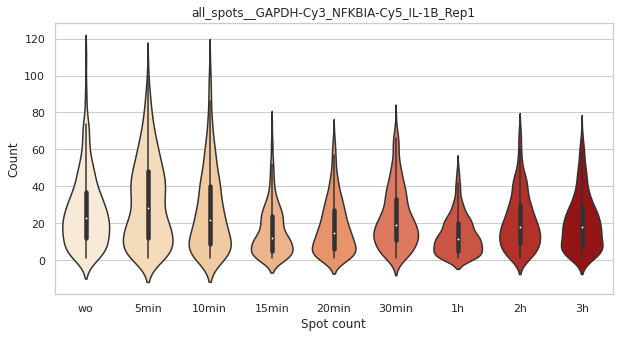

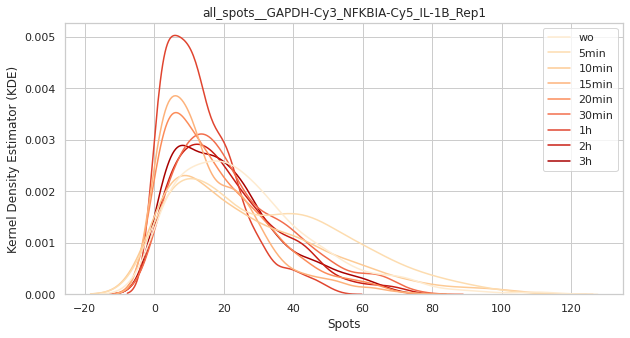

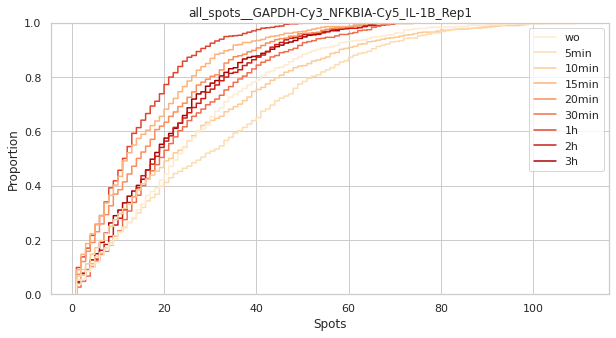

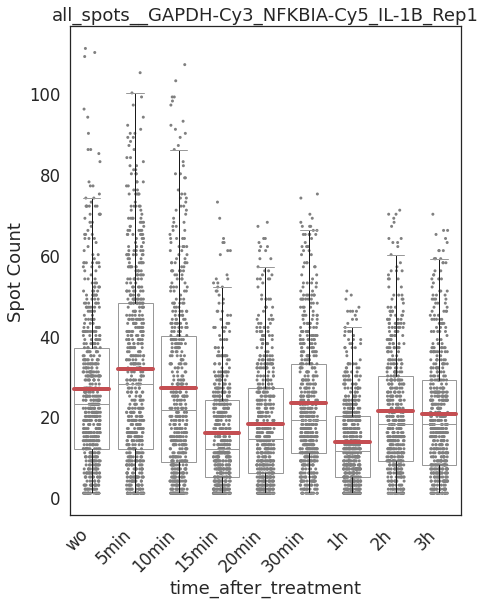

In [23]:
# Plotting for cytosol and nucleus
plot_title_complete = 'all_spots__'+plot_title_subfix
dist_plots(df_all, plot_title_complete, destination_folder)

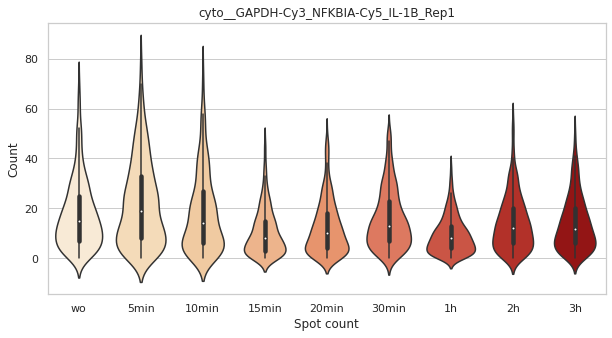

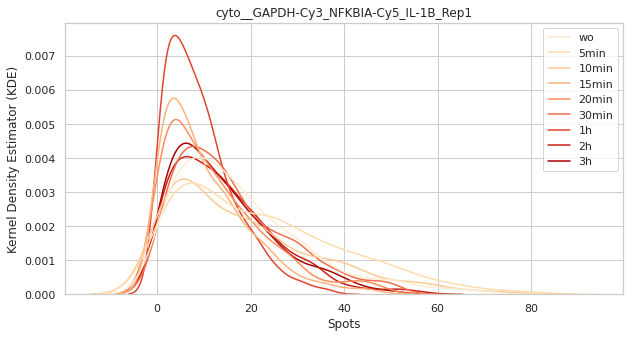

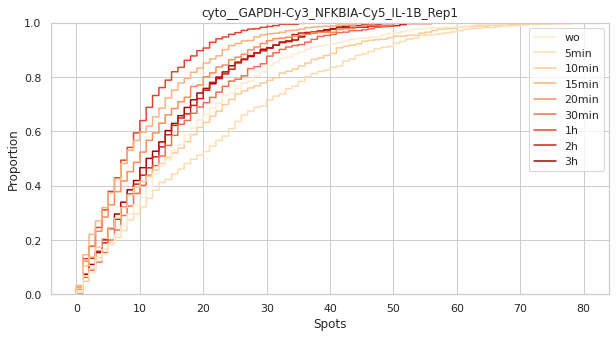

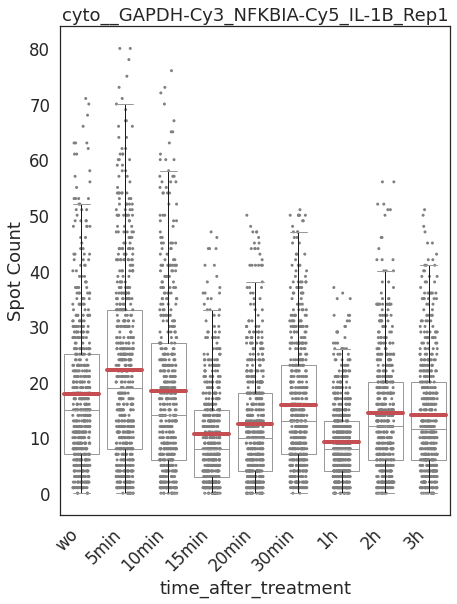

In [24]:
# Plotting for all Cytosol only
plot_title_cyto = 'cyto__'+plot_title_subfix
dist_plots(df_cyto, plot_title_cyto, destination_folder)

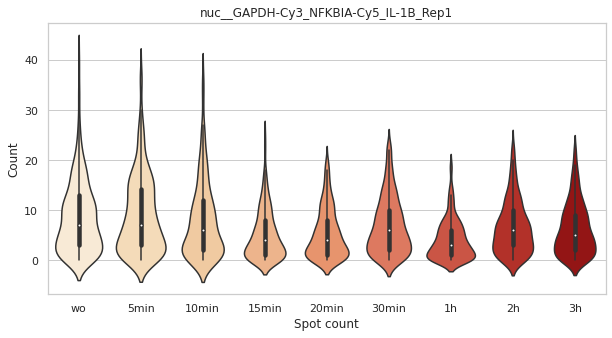

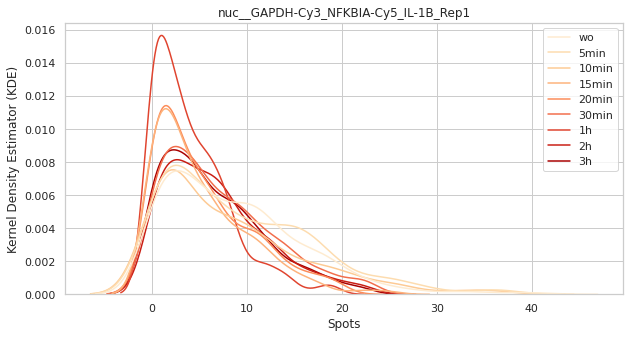

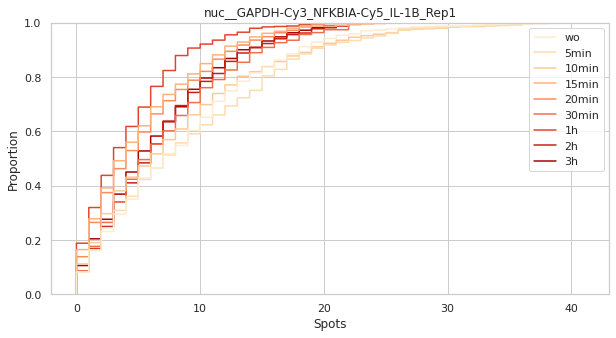

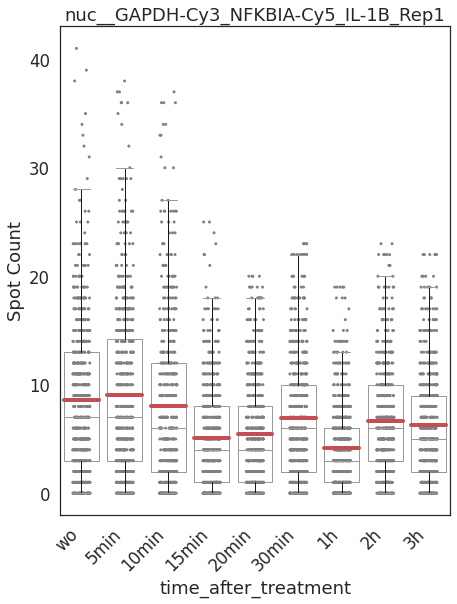

In [25]:
# Plotting for all nucleus
plot_title_nuc = 'nuc__'+plot_title_subfix
dist_plots(df_nuc, plot_title_nuc, destination_folder)

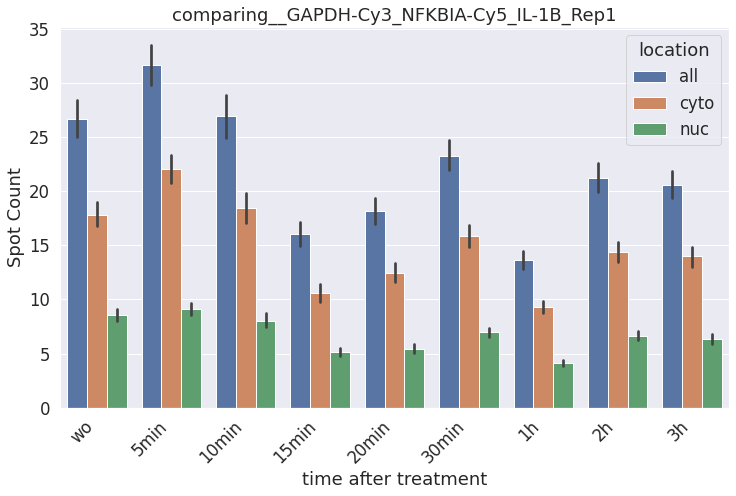

In [26]:
# Plot that compares nuc, cyto, and spots in all cell.
plot_title_comparing = 'comparing__'+plot_title_subfix
plot_comparing_df(df_all,df_cyto,df_nuc,plot_title_comparing,destination_folder)

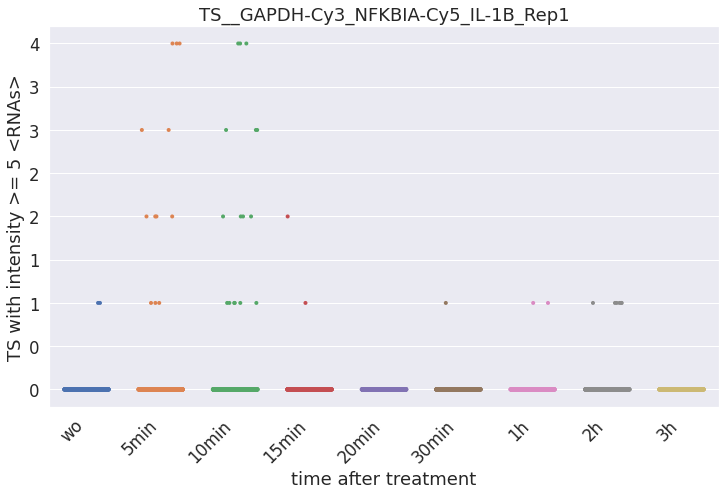

In [27]:
# Plotting for TS
plot_title = 'TS__'+plot_title_subfix
plot_TS(df_transcription_sites,plot_title,destination_folder,minimal_TS_size,remove_zeros=False)

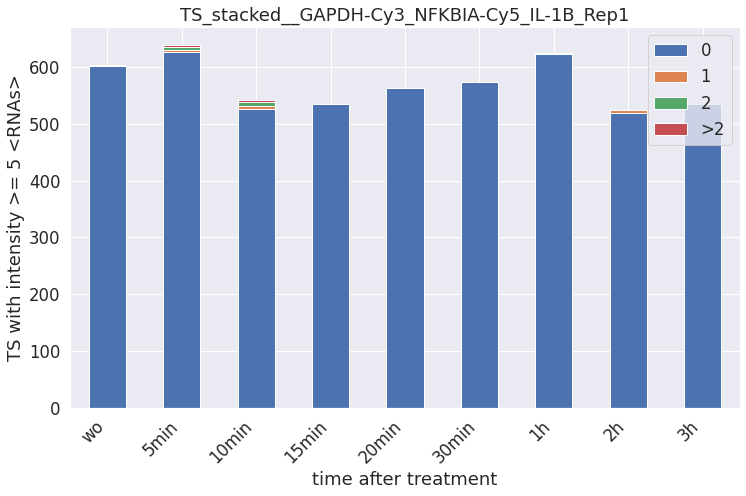

In [28]:
plot_title = 'TS_stacked__'+plot_title_subfix
plot_TS_bar_stacked(df_transcription_sites,plot_title,destination_folder,minimal_TS_size)

In [29]:
# remove temporary folder
shutil.rmtree(local_folder_path)